# Volume 3: Metropolis. Solutions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 100
np.random.binomial(2, 0.5, size=(n,n))

array([[1, 0, 0, ..., 0, 2, 2],
       [2, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 2, 0],
       ...,
       [0, 1, 1, ..., 0, 1, 2],
       [2, 2, 0, ..., 1, 2, 2],
       [2, 1, 2, ..., 2, 0, 2]])

## Problem 1

Write a function that accepts an integer $n$ and returns a random spin configuration for an $n \times n$ lattice (as an $n \times n$ NumPy array of $1$s and $-1$s).
Test your function with $n = 100$, plotting the spin configuration via `plt.imshow()`.

In [3]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    lattice = np.random.binomial(1, 0.5, size=(n,n))
    return 2*lattice - 1

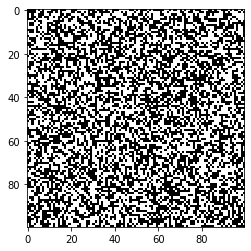

In [4]:
lattice = random_lattice(100)
plt.imshow(lattice, cmap="gray")
plt.show()

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [5]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    """
    # Horizontal sums
    s1 = (L * np.roll(L, 1, axis=0)).sum()
    # Vertical sums
    s2 = (L * np.roll(L, 1, axis=1)).sum()
    return -(s1 + s2)

In [6]:
L = random_lattice(100)

In [7]:
lattice_energy(L)

-24

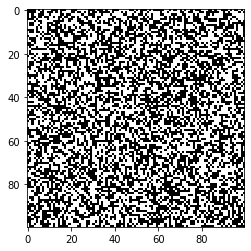

In [8]:
plt.imshow(lattice, cmap="gray")
plt.show()

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [9]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1."""
    i = np.random.randint(0, n)
    j = np.random.randint(0, n)
    return i,j

In [10]:
flip_location(100)

(6, 71)

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [11]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    """
    n = len(L)
    # Update the energy using Equation 1.2
    sum_factor = L[i,j]*(L[(i+1) % n,j] + L[i-1, j] + L[i,(j+1) % n] + L[i,j-1])
    return L_energy + 2*sum_factor

In [12]:
n = 100
# Make random lattice and calculate the energy
L = random_lattice(n)
L_energy = lattice_energy(L)
# Choose a random point to flip
i,j = flip_location(n)
# Create a new lattice with the point flipped
L_new = L.copy()
L_new[i,j] = 1 if L[i,j] == -1 else -1
# Calculate the new energy using updated_energy
e = updated_energy(L, L_energy, i, j)
print(e)
# Calculate the new energy using the new lattice
print(lattice_energy(L_new))
# Compare to the old energy
print(L_energy)

-32
-32
-28


## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

In [13]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration."""
    log_ratio = beta * (energy_old - energy_new)
    # Accept automatically if ratio > 1
    if log_ratio > 0:
        return True
    else:
        # Choose a uniform random between 0 and 1 and determine whether to accept the lattice
        u = np.random.uniform()
        if np.log(u) <= log_ratio:
            return True
        else: return False

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [14]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    # Initialize random lattice
    L = random_lattice(n)
    weighted_energy = []
    samples = []
    accept_count = 0
    for k in range(burn_in + n_samples):
        i,j = flip_location(n)
        # Update energy
        energy_old = lattice_energy(L)
        energy_new = updated_energy(L, energy_old, i, j)
        # Flip the splin if accepted
        if accept(beta, energy_old, energy_new):
            L[i,j] = 1 if L[i,j] == -1 else -1
            accept_count+=1
        weighted_energy.append(-beta * energy_old)
        # After the burn in period, record several samples
        if k >= burn_in:
            if k % 100 == 0:
                samples.append(np.copy(L))
        
#         if k % 1000 == 0:
#             print(energy_old, energy_new, np.exp(beta * (energy_old - energy_new)))
    return samples, weighted_energy, accept_count / (burn_in + n_samples)

### Beta = 0.1

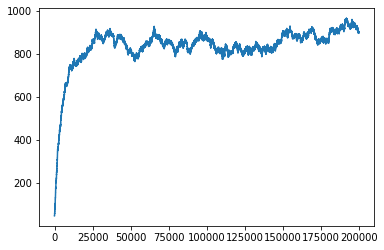

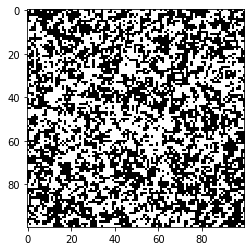

-4496.464
-0.2248232


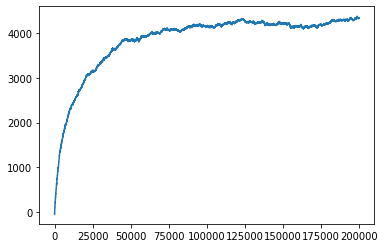

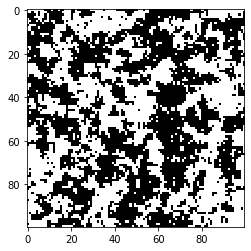

-10530.808
-0.5265404


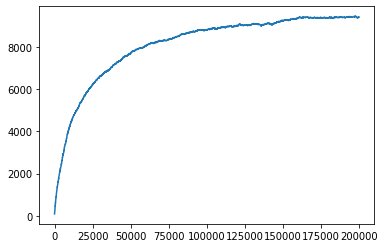

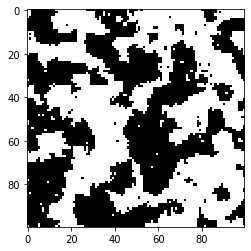

-15610.096
-0.7805048


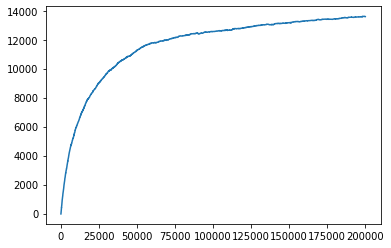

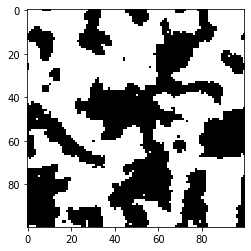

-16756.72
-0.837836


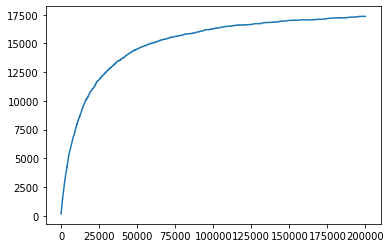

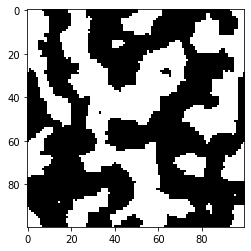

-17162.424
-0.8581211999999999


In [16]:
n = 100
for beta in [0.2, 0.4, 0.6, 0.8, 1]:
    samples, weighted_energy, rate = ising_metropolis(beta, n=n, n_samples=50000, burn_in=150000)
    plt.plot(weighted_energy)
    plt.show()
    plt.imshow(samples[-1], cmap="gray")
    plt.show()
    print(np.mean([lattice_energy(L) for L in samples]))
    print(np.mean([lattice_energy(L) for L in samples]) / (2*n**2))

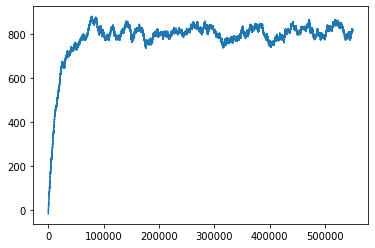

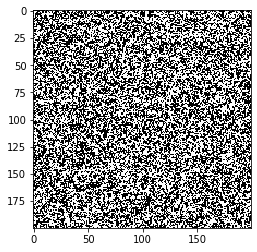

-8209.224
-0.1026153


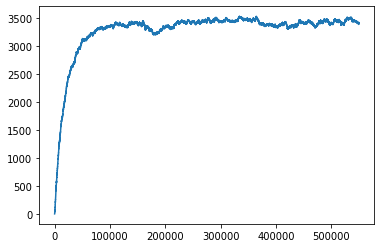

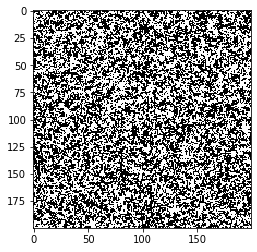

-17198.92
-0.21498649999999997


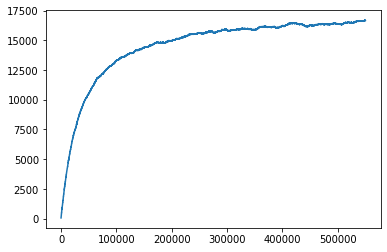

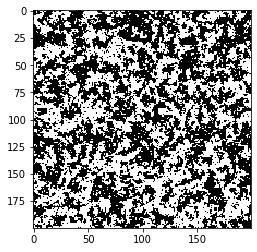

-41255.216
-0.5156902


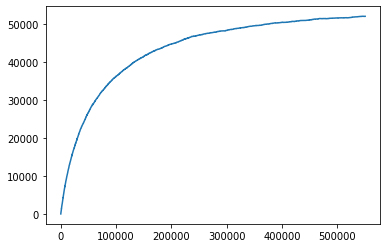

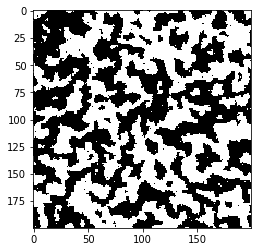

-64703.112
-0.8087889


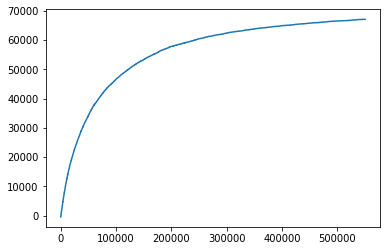

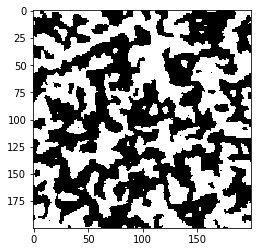

-66863.64
-0.8357955


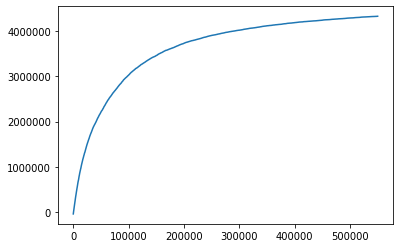

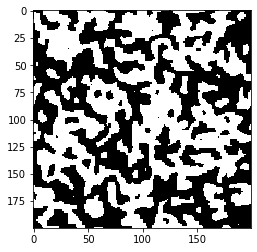

-67176.832
-0.8397104


In [108]:
n = 200
for beta in [0.1, 0.2, 0.4, 0.8, 1, 64]:
    samples, weighted_energy, rate = ising_metropolis(beta, n=n, n_samples=50000, burn_in=500000)
    plt.plot(weighted_energy)
    plt.show()
    plt.imshow(samples[-1], cmap="gray")
    plt.show()
    print(np.mean([lattice_energy(L) for L in samples]))
    print(np.mean([lattice_energy(L) for L in samples]) / (2*n**2))

In [27]:
import time

In [39]:
start = time.time()
ising_samples = []
for i in range(30000):
    samples, weighted_energy, rate = ising_metropolis(0.4, n=64, n_samples=1, burn_in=40000)
    ising_samples.append(samples[0])
    if i % 1000 == 0:
        elapsed = time.time() - start
        print("{:.1f}".format(elapsed), "\t\t", i)

2.7 		 0
2726.2 		 1000
5445.0 		 2000
8066.7 		 3000
10678.3 		 4000
13295.1 		 5000
15902.6 		 6000
18511.1 		 7000
21123.9 		 8000
23728.6 		 9000
26334.5 		 10000
28953.4 		 11000
31566.2 		 12000
34182.1 		 13000
36799.5 		 14000
39432.3 		 15000
42045.6 		 16000
44652.1 		 17000
47258.4 		 18000
49863.6 		 19000
52461.8 		 20000
55062.6 		 21000
57661.2 		 22000
60253.9 		 23000
62857.2 		 24000
65471.7 		 25000
68072.1 		 26000
70686.7 		 27000
73297.3 		 28000
75921.2 		 29000


In [40]:
np.save("ising_samples.npy", np.stack(ising_samples))

In [6]:
import torch
from torch.autograd import Function
from torch import nn

In [7]:
class StepTanh(Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        input[input>0] = 1
        input[input<=0] = -1
        return input
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_temp = grad_output.clone()
        grad_input = grad_temp * (1 - torch.tanh(input).pow(2))
        return grad_input
    
class LeakySine(Function):
    
    @staticmethod
    def forward(ctx, x, slope):
        ctx.save_for_backward(x)
        ctx.slope = slope
        y = x.clone()
        
        x1 = x[x <= -np.pi/2]
        x2 = x[(x > -np.pi/2) & (x < np.pi/2)]
        x3 = x[x >= np.pi/2]
        
        x[y <= -np.pi/2] = slope * (x1 + np.pi/2) - 1
        x[(y > -np.pi/2) & (x < np.pi/2)] = torch.sin(x2)
        x[y >= np.pi/2] = slope * (x3 - np.pi/2) + 1
        return x
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_temp = grad_output.clone()
        grad_input = grad_output.clone()
        mask1 = (input <= -np.pi/2) & (input >= np.pi/2)
        mask2 = (input > -np.pi/2) & (input < np.pi/2)
        grad_input[mask1] = grad_temp[mask1] * ctx.slope
        grad_input[mask2] = grad_temp[mask2] * torch.cos(input[mask2])
        return grad_input, None
    
def odd_pow(input, exponent):
    return input.sign() * input.abs().pow(exponent)

class ImageEncoder(nn.Module):
    def __init__(self, d_model, num_layers, f, d, activation=nn.ReLU, dropout=0.1):
        super(ImageEncoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.d = d
        self.ff = nn.Linear(d_model, f*d_model)
        F = f*d_model
        self.conv_in = nn.Conv2d(\
            d_model*f // (d**2), F, 3, stride=1, padding=0
        )
        self.bn = nn.ModuleList(\
            nn.BatchNorm2d(F//(2**i)) for i in range(1, num_layers+1)
        )
        self.upsample = nn.ModuleList(\
            nn.Upsample(scale_factor=2, 
            mode="bilinear",
            align_corners=False) 
            for i in range(num_layers)
        )
        self.convs = nn.ModuleList(\
            nn.Conv2d(F//(2**i), 
            F//(2**(i+1)), 
            3, 
            stride=1, 
            padding=0) 
            for i in range(num_layers)
        )
        
        self.conv_out = nn.Conv2d(\
            F//(2**num_layers), 1, 3, stride=1, padding=0
        )

        self.pad = nn.ReflectionPad2d(1)
        self.activation = activation()
        self.dropout = nn.Dropout(p=dropout)
        self.leaky_sin = LeakySine.apply
        
    def forward(self, x, p=False):
        batch_size = x.size(0)
        x = self.ff(x)
        x = x.reshape(batch_size, -1, self.d, self.d)
        x = self.pad(x)
        x = self.conv_in(x)
        for i in range(self.num_layers):
            x = self.upsample[i](x)
            x = self.pad(x)
            x = self.convs[i](x)
            x = self.dropout(x)
            x = self.activation(x)
            x = self.bn[i](x)
        x = self.pad(x)
        x = self.conv_out(x)
        y = torch.clone(x)
        x = torch.tanh(x)
        return x.squeeze(), y

In [8]:
def torch_lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    """
    # Horizontal sums
    s1 = torch.sum((L * torch.roll(L, 1, 1)), (1, 2))
    # Vertical sums
    s2 = torch.sum((L * torch.roll(L, 1, 2)), (1, 2))
    return -(s1 + s2)

In [9]:
c = -1/2 * np.log(np.exp(1/2) - 1)
def energy_beta_func(x):
    return -2 * torch.log(1 + torch.exp(-2*(1/x + c))) + 1
def energy_beta_func_inverse(y):
    return -2 / (torch.log(torch.exp((1-y)/2) - 1) + 2*c)
def sample_norms(n):
    norms = torch.rand(n)
    norms = energy_beta_func_inverse(norms)
    return norms
def sample_inputs(n, d_model, device):
    norms = sample_norms(n)
    x = torch.randn(n, d_model).to(device) / np.sqrt(d_model)
    return norms.unsqueeze(1) * x

In [26]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()
def get_std_opt(model):
    return NoamOpt(model.d_model, 2, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [33]:
d_model = 128
n = 128
x = torch.randn(10, d_model)
IsingModel = ImageEncoder(d_model, 4, 2, 4)
image, _ = IsingModel(x)
e_max = 2*64**2
beta = 0.6

In [34]:
cuda = torch.device("cuda")
IsingModel = IsingModel.to(cuda)
optimizer = torch.optim.SGD(IsingModel.parameters(), lr=0.01)
#optimizer = get_std_opt(IsingModel)
#optimizer = torch.optim.Adam(IsingModel.parameters(), lr=0.001)

Iter:  0
Energy Loss: 	0.24985
Sum Loss: 	0.86495
Norm Loss: 	0.00005


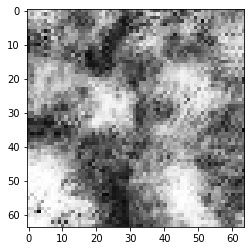

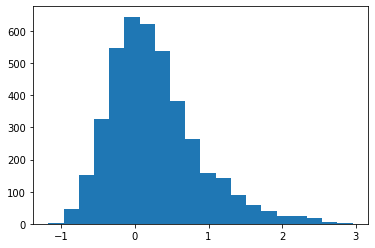

Iter:  100
Energy Loss: 	0.06011
Sum Loss: 	0.14197
Norm Loss: 	0.00229


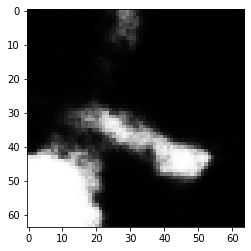

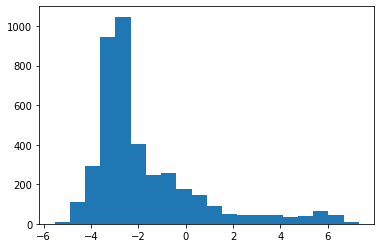

Iter:  200
Energy Loss: 	0.06021
Sum Loss: 	0.12974
Norm Loss: 	0.00257


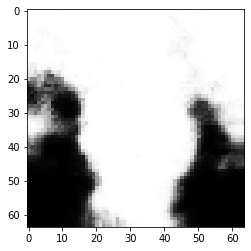

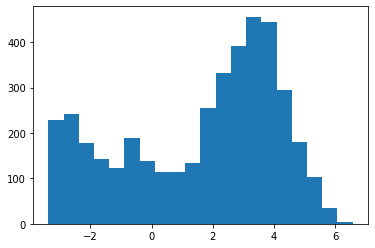

Iter:  300
Energy Loss: 	0.06340
Sum Loss: 	0.12138
Norm Loss: 	0.00286


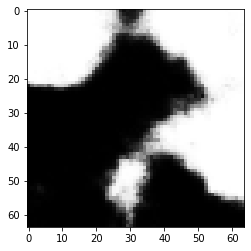

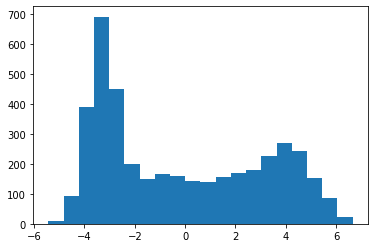

Iter:  400
Energy Loss: 	0.06352
Sum Loss: 	0.11694
Norm Loss: 	0.00303


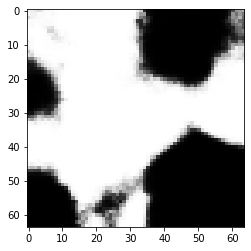

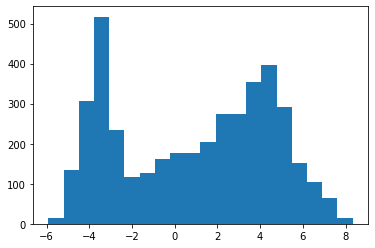

Iter:  500
Energy Loss: 	0.05998
Sum Loss: 	0.11968
Norm Loss: 	0.00318


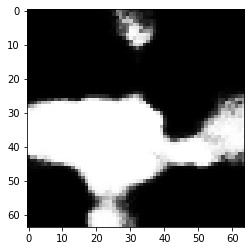

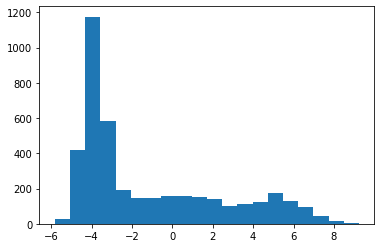

Iter:  600
Energy Loss: 	0.06011
Sum Loss: 	0.11670
Norm Loss: 	0.00333


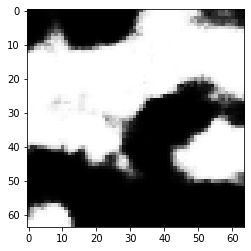

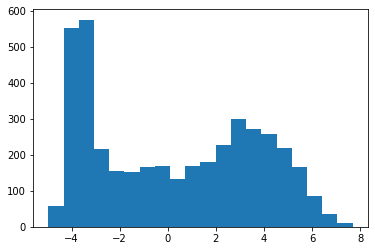

Iter:  700
Energy Loss: 	0.05698
Sum Loss: 	0.11861
Norm Loss: 	0.00360


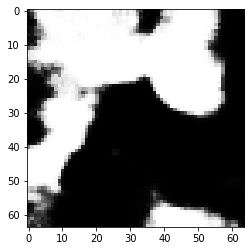

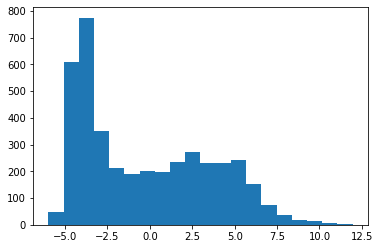

Iter:  800
Energy Loss: 	0.05563
Sum Loss: 	0.11658
Norm Loss: 	0.00398


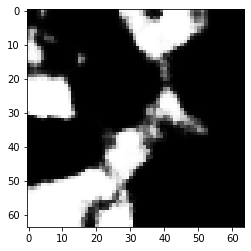

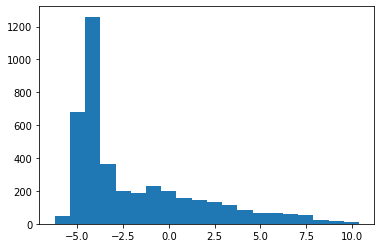

Iter:  900
Energy Loss: 	0.04969
Sum Loss: 	0.12069
Norm Loss: 	0.00436


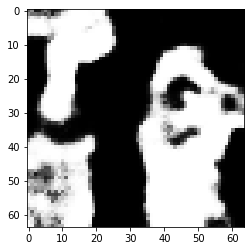

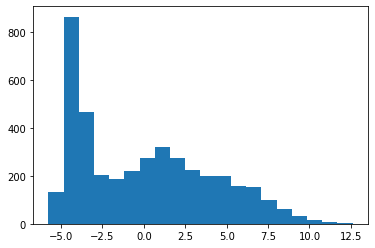

Iter:  1000
Energy Loss: 	0.04711
Sum Loss: 	0.11647
Norm Loss: 	0.00489


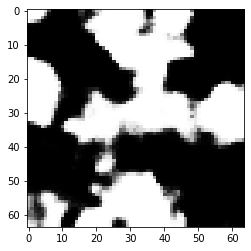

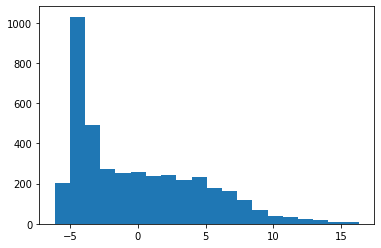

Iter:  1100
Energy Loss: 	0.04150
Sum Loss: 	0.11431
Norm Loss: 	0.00558


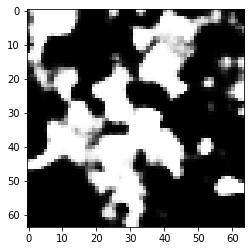

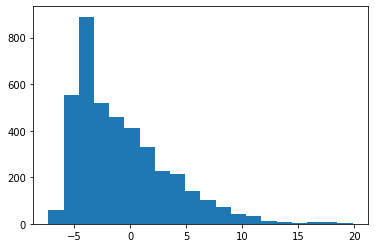

Iter:  1200
Energy Loss: 	0.03560
Sum Loss: 	0.10847
Norm Loss: 	0.00644


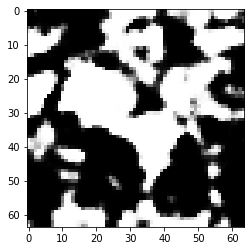

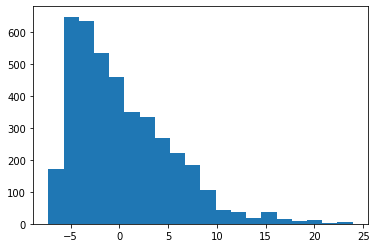

Iter:  1300
Energy Loss: 	0.03424
Sum Loss: 	0.09673
Norm Loss: 	0.00757


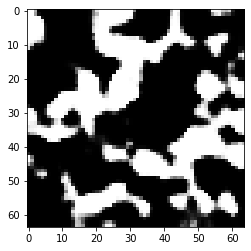

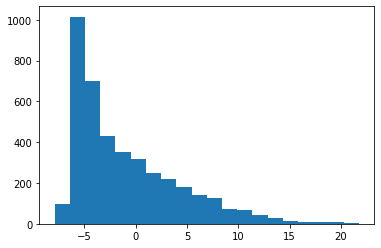

Iter:  1400
Energy Loss: 	0.03139
Sum Loss: 	0.09433
Norm Loss: 	0.00852


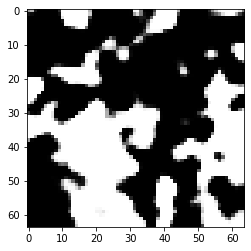

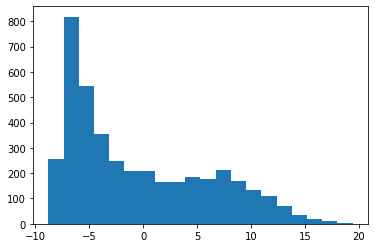

Iter:  1500
Energy Loss: 	0.03034
Sum Loss: 	0.08705
Norm Loss: 	0.00945


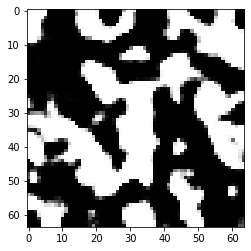

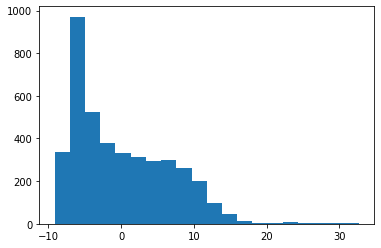

Iter:  1600
Energy Loss: 	0.03158
Sum Loss: 	0.07642
Norm Loss: 	0.01084


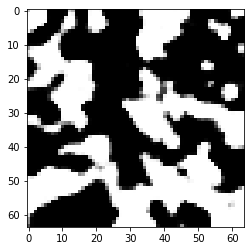

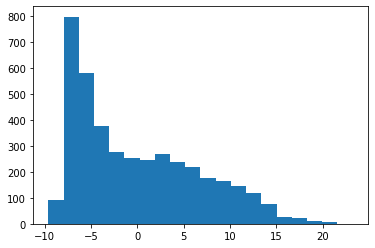

Iter:  1700
Energy Loss: 	0.02880
Sum Loss: 	0.07525
Norm Loss: 	0.01149


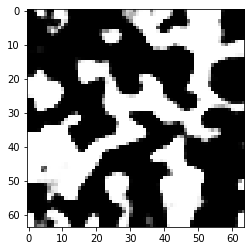

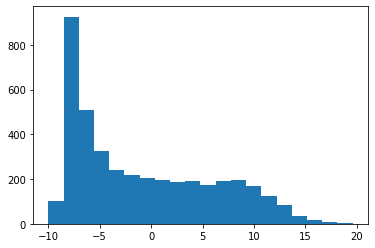

Iter:  1800
Energy Loss: 	0.02891
Sum Loss: 	0.07872
Norm Loss: 	0.01166


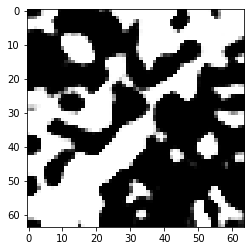

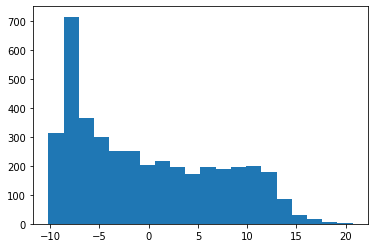

Iter:  1900
Energy Loss: 	0.02664
Sum Loss: 	0.07768
Norm Loss: 	0.01217


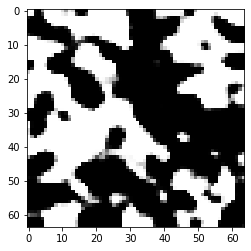

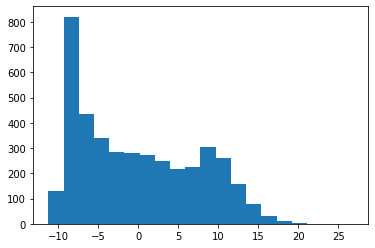

Iter:  2000
Energy Loss: 	0.02879
Sum Loss: 	0.06516
Norm Loss: 	0.01383


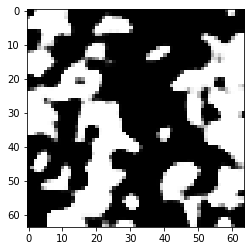

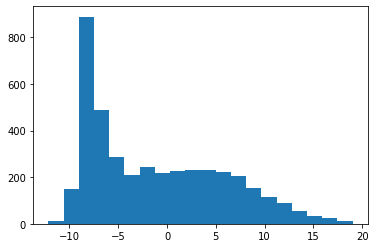

Iter:  2100
Energy Loss: 	0.02454
Sum Loss: 	0.06711
Norm Loss: 	0.01395


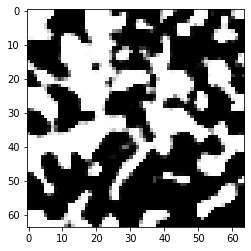

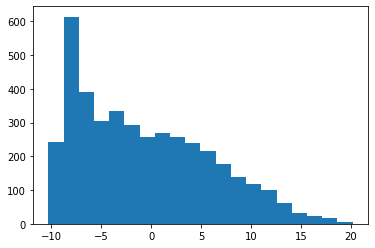

Iter:  2200
Energy Loss: 	0.02575
Sum Loss: 	0.06455
Norm Loss: 	0.01466


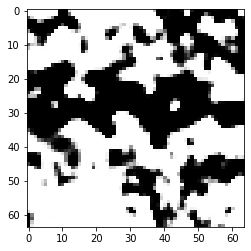

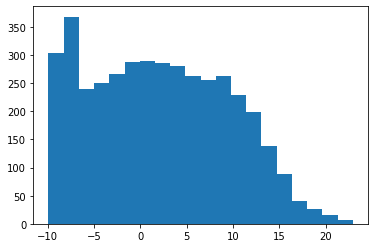

Iter:  2300
Energy Loss: 	0.02184
Sum Loss: 	0.06637
Norm Loss: 	0.01456


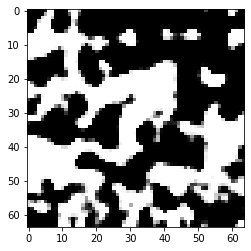

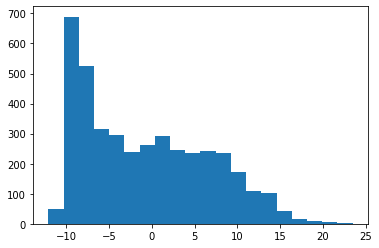

Iter:  2400
Energy Loss: 	0.02049
Sum Loss: 	0.06455
Norm Loss: 	0.01495


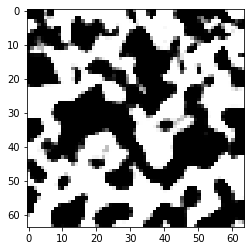

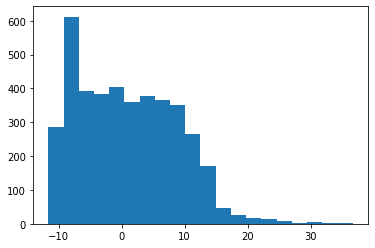

Iter:  2500
Energy Loss: 	0.01638
Sum Loss: 	0.06967
Norm Loss: 	0.01442


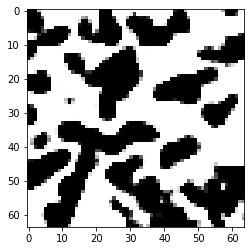

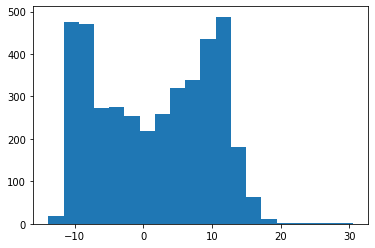

Iter:  2600
Energy Loss: 	0.01497
Sum Loss: 	0.07067
Norm Loss: 	0.01441


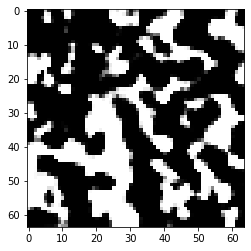

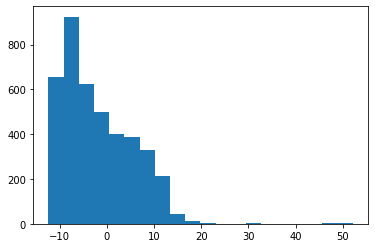

Iter:  2700
Energy Loss: 	0.02558
Sum Loss: 	0.05443
Norm Loss: 	0.01731


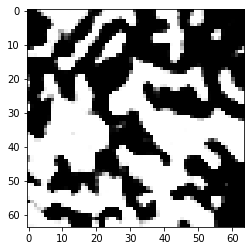

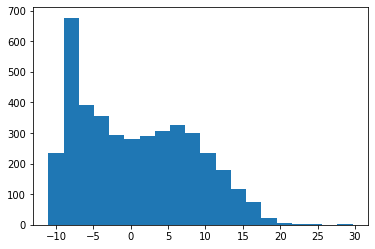

Iter:  2800
Energy Loss: 	0.02385
Sum Loss: 	0.06576
Norm Loss: 	0.01570


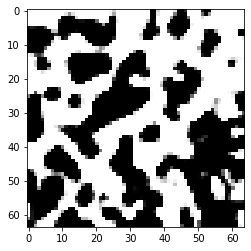

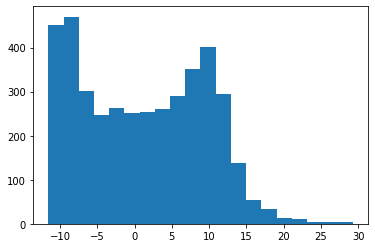

Iter:  2900
Energy Loss: 	0.01229
Sum Loss: 	0.06657
Norm Loss: 	0.01561


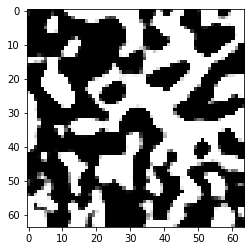

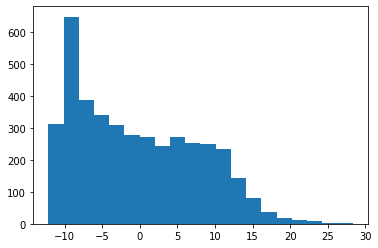

Iter:  3000
Energy Loss: 	0.01443
Sum Loss: 	0.06088
Norm Loss: 	0.01630


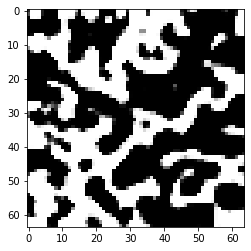

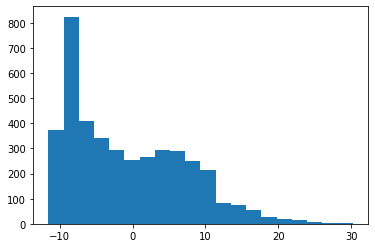

Iter:  3100
Energy Loss: 	0.01047
Sum Loss: 	0.06778
Norm Loss: 	0.01566


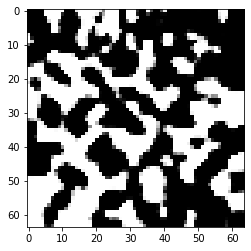

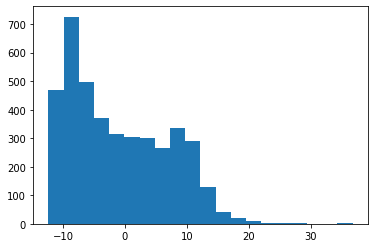

Iter:  3200
Energy Loss: 	0.01001
Sum Loss: 	0.06844
Norm Loss: 	0.01581


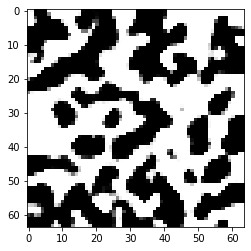

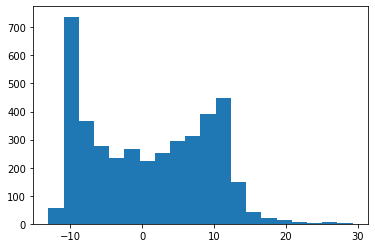

Iter:  3300
Energy Loss: 	0.01161
Sum Loss: 	0.05999
Norm Loss: 	0.01719


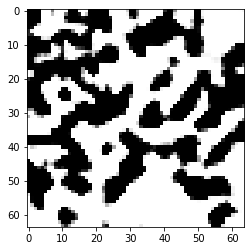

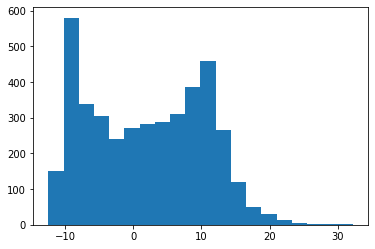

Iter:  3400
Energy Loss: 	0.00984
Sum Loss: 	0.06056
Norm Loss: 	0.01715


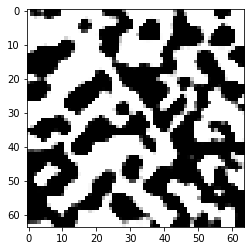

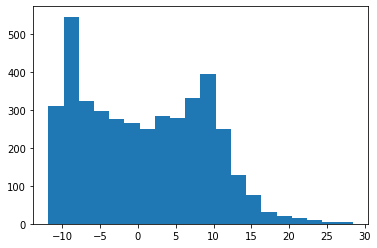

Iter:  3500
Energy Loss: 	0.01178
Sum Loss: 	0.05784
Norm Loss: 	0.01741


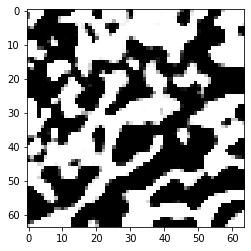

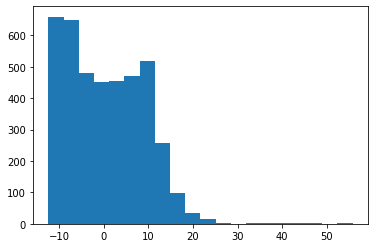

Iter:  3600
Energy Loss: 	0.00879
Sum Loss: 	0.06173
Norm Loss: 	0.01710


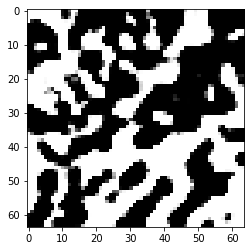

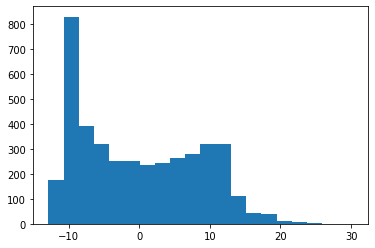

Iter:  3700
Energy Loss: 	0.00720
Sum Loss: 	0.06353
Norm Loss: 	0.01698


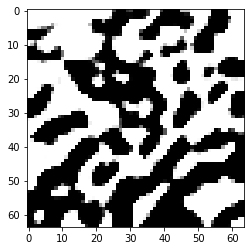

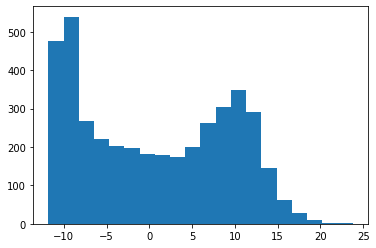

Iter:  3800
Energy Loss: 	0.00784
Sum Loss: 	0.06050
Norm Loss: 	0.01753


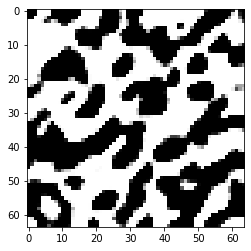

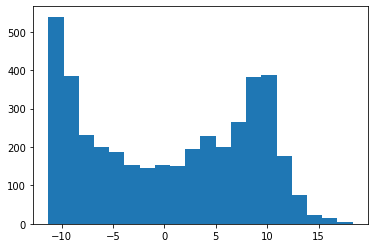

Iter:  3900
Energy Loss: 	0.00694
Sum Loss: 	0.06002
Norm Loss: 	0.01766


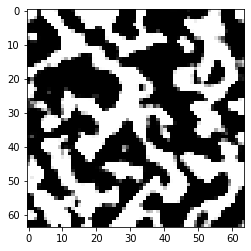

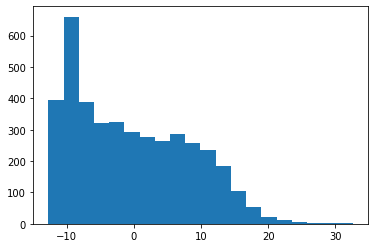

Iter:  4000
Energy Loss: 	0.00739
Sum Loss: 	0.05817
Norm Loss: 	0.01835


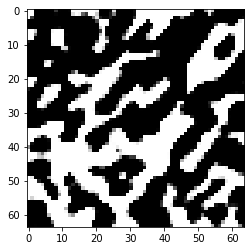

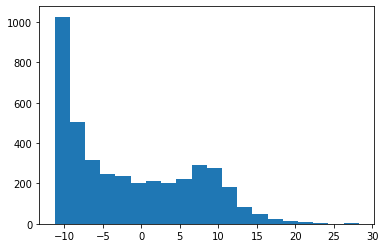

Iter:  4100
Energy Loss: 	0.00831
Sum Loss: 	0.05674
Norm Loss: 	0.01791


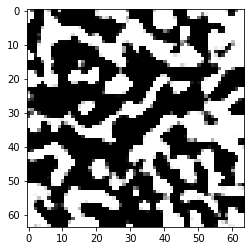

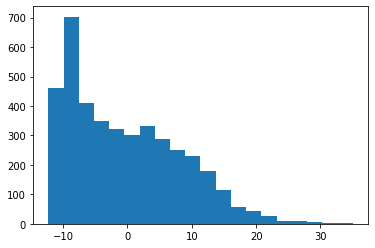

Iter:  4200
Energy Loss: 	0.00989
Sum Loss: 	0.05246
Norm Loss: 	0.01892


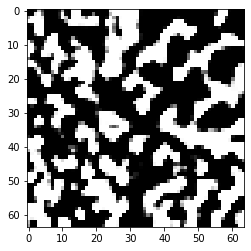

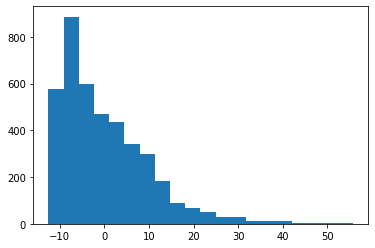

Iter:  4300
Energy Loss: 	0.00725
Sum Loss: 	0.05878
Norm Loss: 	0.01949


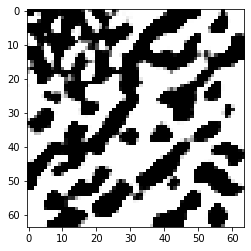

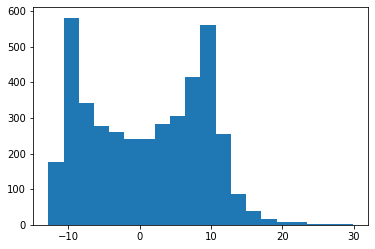

Iter:  4400
Energy Loss: 	0.00557
Sum Loss: 	0.05920
Norm Loss: 	0.01838


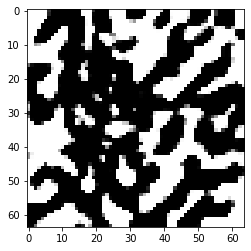

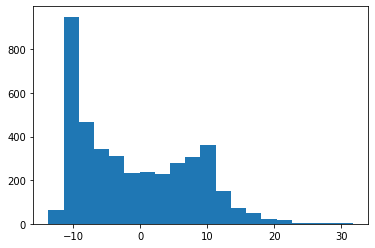

Iter:  4500
Energy Loss: 	0.00533
Sum Loss: 	0.06016
Norm Loss: 	0.01840


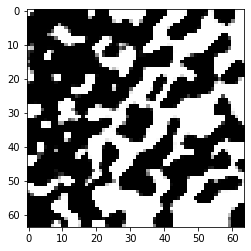

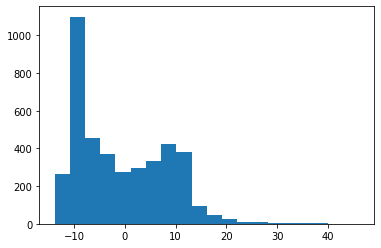

Iter:  4600
Energy Loss: 	0.00633
Sum Loss: 	0.05516
Norm Loss: 	0.01869


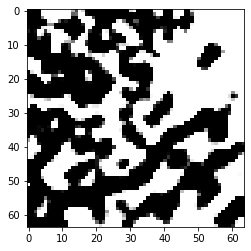

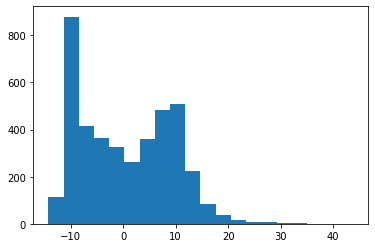

Iter:  4700
Energy Loss: 	0.00867
Sum Loss: 	0.05029
Norm Loss: 	0.01977


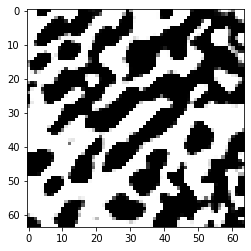

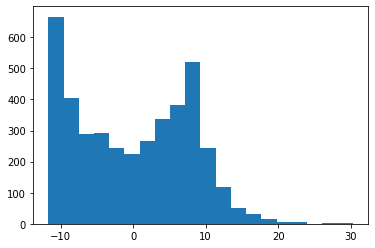

Iter:  4800
Energy Loss: 	0.00565
Sum Loss: 	0.05464
Norm Loss: 	0.01978


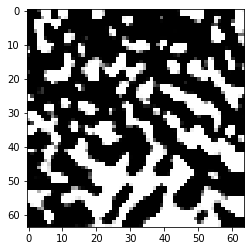

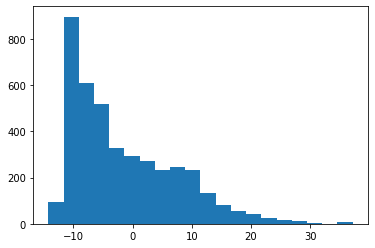

Iter:  4900
Energy Loss: 	0.00619
Sum Loss: 	0.05370
Norm Loss: 	0.02028


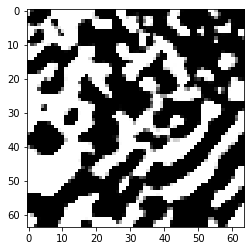

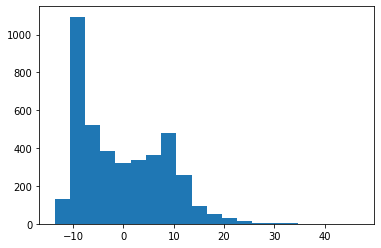

Iter:  5000
Energy Loss: 	0.01002
Sum Loss: 	0.05817
Norm Loss: 	0.01981


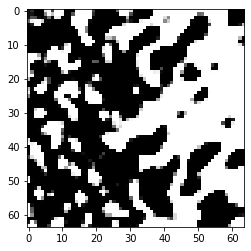

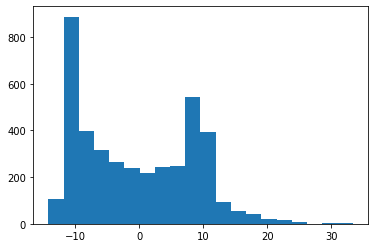

Iter:  5100
Energy Loss: 	0.00506
Sum Loss: 	0.05538
Norm Loss: 	0.01923


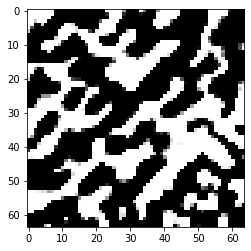

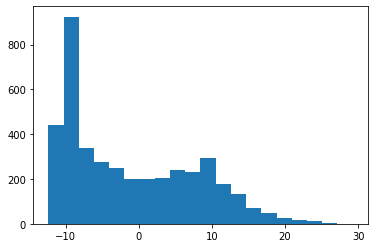

Iter:  5200
Energy Loss: 	0.00489
Sum Loss: 	0.05546
Norm Loss: 	0.01823


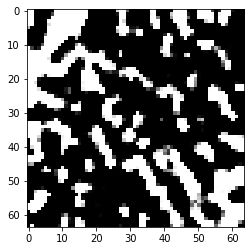

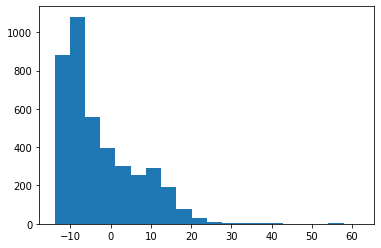

Iter:  5300
Energy Loss: 	0.00416
Sum Loss: 	0.05878
Norm Loss: 	0.01900


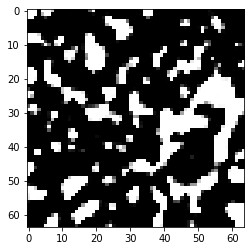

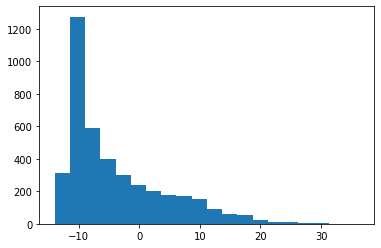

Iter:  5400
Energy Loss: 	0.00518
Sum Loss: 	0.05234
Norm Loss: 	0.01932


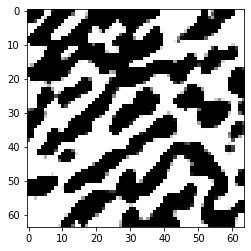

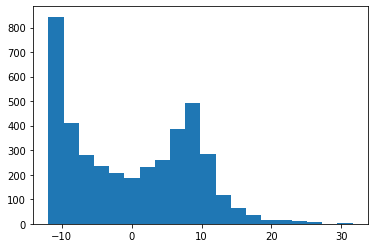

Iter:  5500
Energy Loss: 	0.00746
Sum Loss: 	0.04841
Norm Loss: 	0.01977


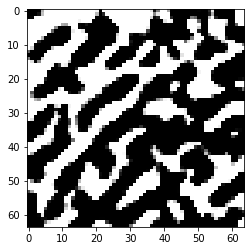

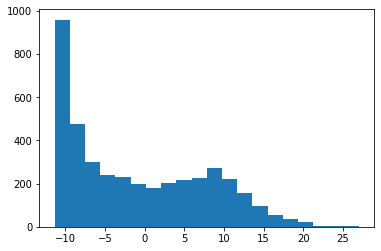

Iter:  5600
Energy Loss: 	0.00519
Sum Loss: 	0.05089
Norm Loss: 	0.02020


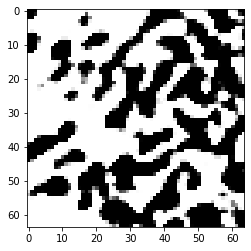

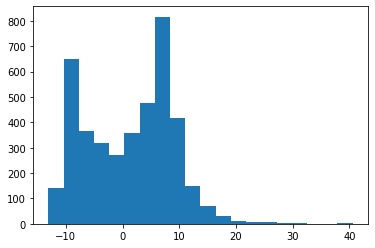

Iter:  5700
Energy Loss: 	0.00403
Sum Loss: 	0.05282
Norm Loss: 	0.01933


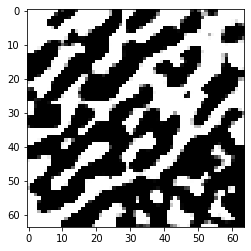

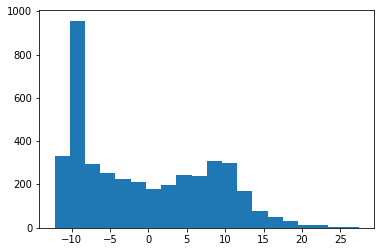

Iter:  5800
Energy Loss: 	0.00427
Sum Loss: 	0.05241
Norm Loss: 	0.01931


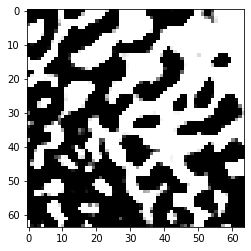

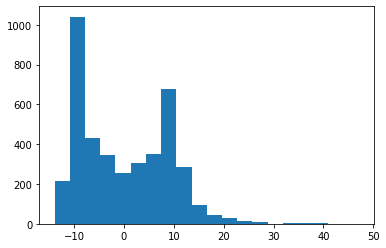

Iter:  5900
Energy Loss: 	0.00469
Sum Loss: 	0.05172
Norm Loss: 	0.02087


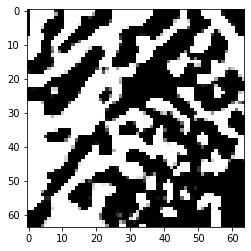

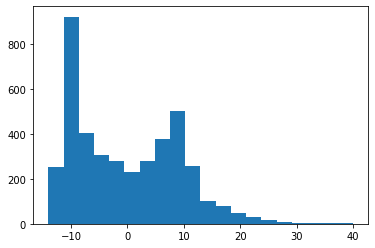

Iter:  6000
Energy Loss: 	0.00397
Sum Loss: 	0.05505
Norm Loss: 	0.01941


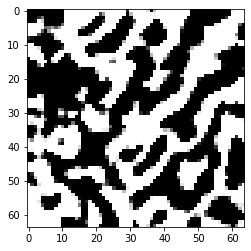

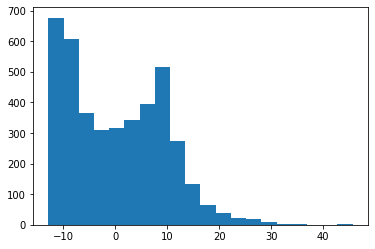

Iter:  6100
Energy Loss: 	0.00578
Sum Loss: 	0.04726
Norm Loss: 	0.02059


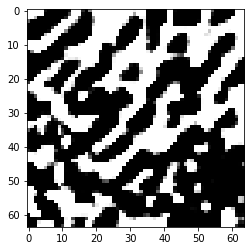

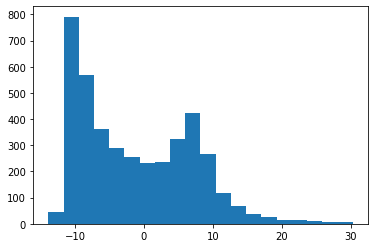

Iter:  6200
Energy Loss: 	0.00442
Sum Loss: 	0.04971
Norm Loss: 	0.02000


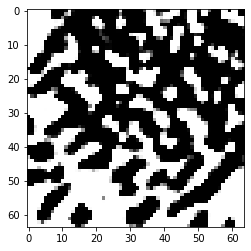

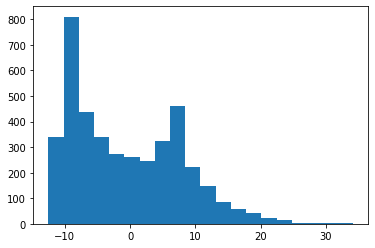

Iter:  6300
Energy Loss: 	0.00599
Sum Loss: 	0.04649
Norm Loss: 	0.02025


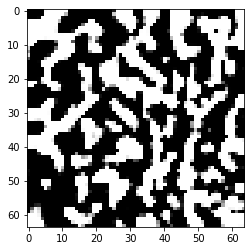

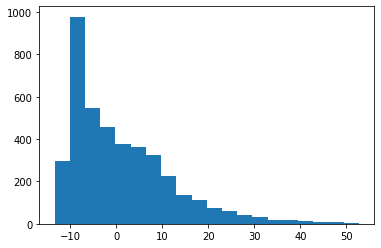

Iter:  6400
Energy Loss: 	0.00413
Sum Loss: 	0.05327
Norm Loss: 	0.02020


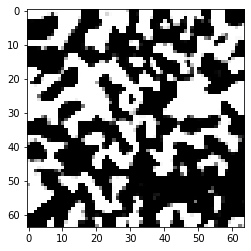

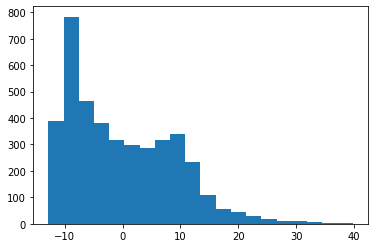

Iter:  6500
Energy Loss: 	0.00470
Sum Loss: 	0.04871
Norm Loss: 	0.02088


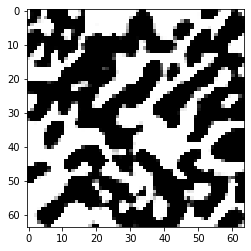

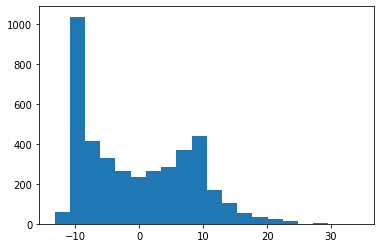

Iter:  6600
Energy Loss: 	0.00520
Sum Loss: 	0.04725
Norm Loss: 	0.02032


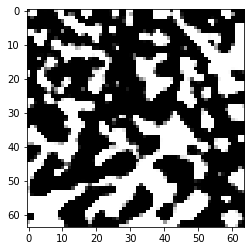

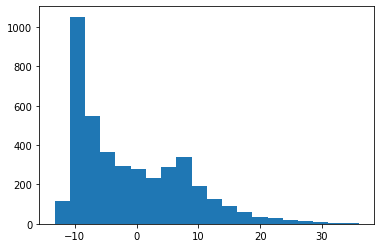

Iter:  6700
Energy Loss: 	0.00445
Sum Loss: 	0.04840
Norm Loss: 	0.02097


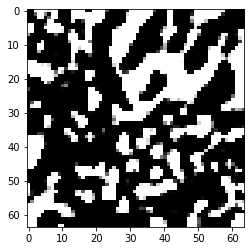

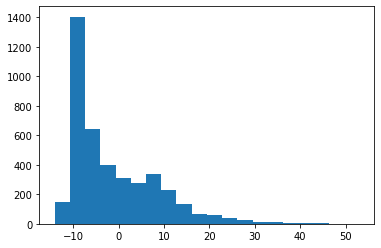

Iter:  6800
Energy Loss: 	0.01205
Sum Loss: 	0.05346
Norm Loss: 	0.02002


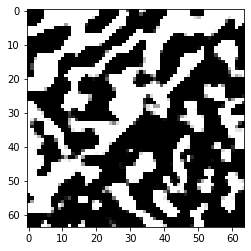

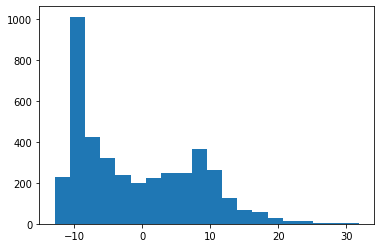

Iter:  6900
Energy Loss: 	0.00689
Sum Loss: 	0.04335
Norm Loss: 	0.02176


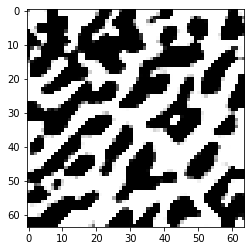

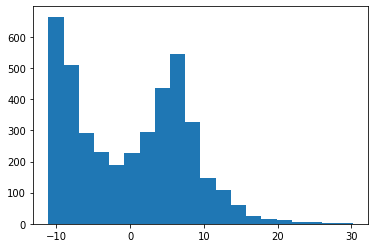

Iter:  7000
Energy Loss: 	0.00669
Sum Loss: 	0.04352
Norm Loss: 	0.01972


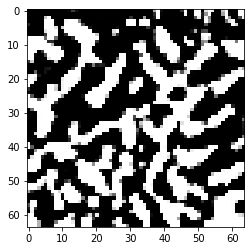

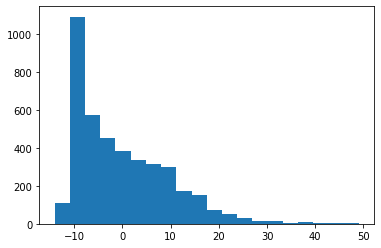

Iter:  7100
Energy Loss: 	0.00494
Sum Loss: 	0.04721
Norm Loss: 	0.01881


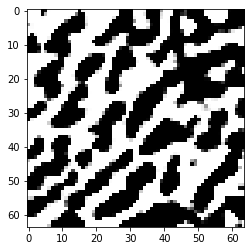

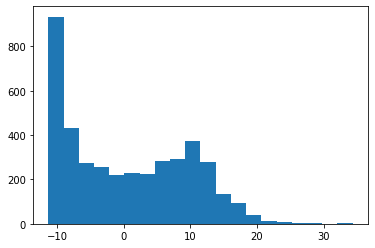

Iter:  7200
Energy Loss: 	0.00569
Sum Loss: 	0.04416
Norm Loss: 	0.01936


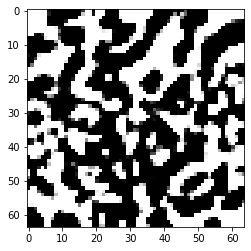

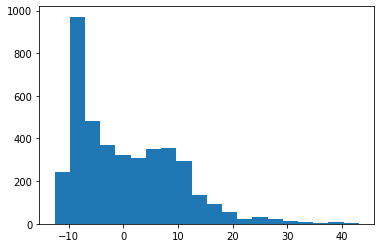

Iter:  7300
Energy Loss: 	0.00601
Sum Loss: 	0.04405
Norm Loss: 	0.01890


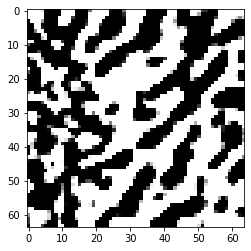

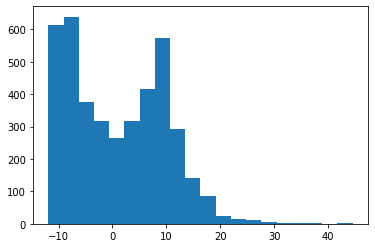

Iter:  7400
Energy Loss: 	0.00391
Sum Loss: 	0.04931
Norm Loss: 	0.01793


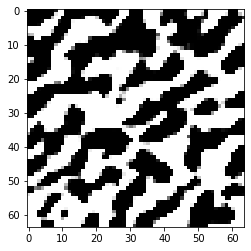

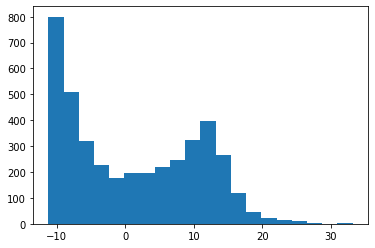

Iter:  7500
Energy Loss: 	0.00438
Sum Loss: 	0.04533
Norm Loss: 	0.02033


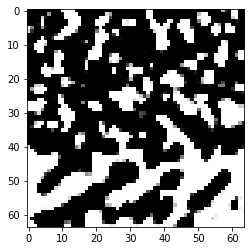

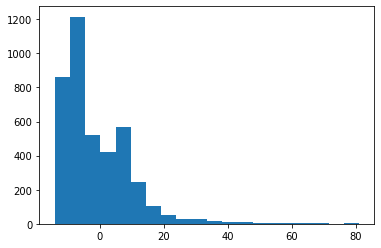

Iter:  7600
Energy Loss: 	0.00569
Sum Loss: 	0.04566
Norm Loss: 	0.02194


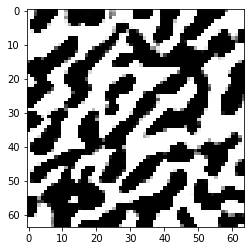

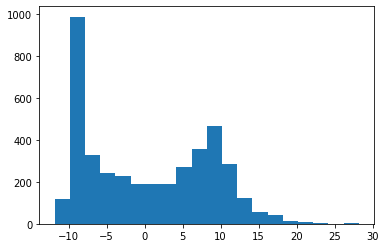

Iter:  7700
Energy Loss: 	0.00749
Sum Loss: 	0.04027
Norm Loss: 	0.02063


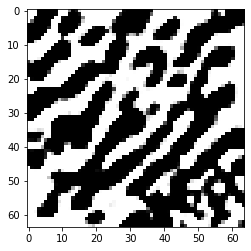

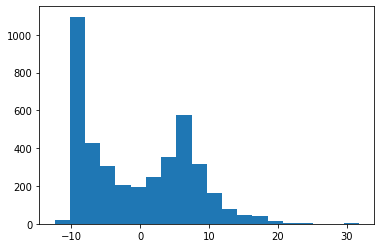

Iter:  7800
Energy Loss: 	0.00289
Sum Loss: 	0.04891
Norm Loss: 	0.01809


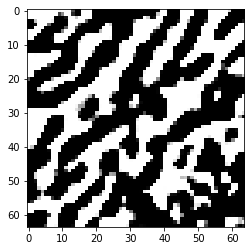

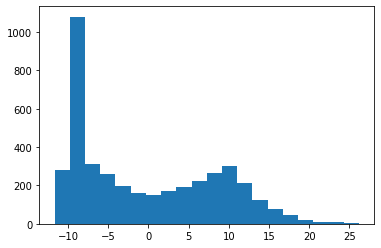

Iter:  7900
Energy Loss: 	0.00699
Sum Loss: 	0.04222
Norm Loss: 	0.02212


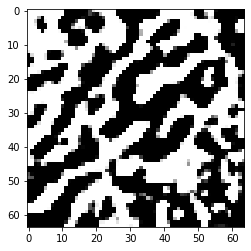

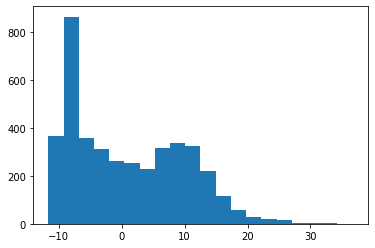

Iter:  8000
Energy Loss: 	0.00482
Sum Loss: 	0.04402
Norm Loss: 	0.01796


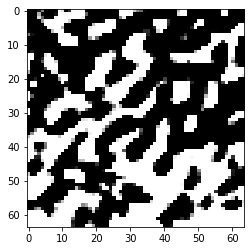

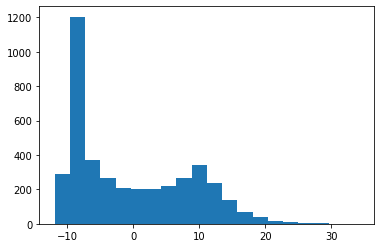

Iter:  8100
Energy Loss: 	0.00494
Sum Loss: 	0.04282
Norm Loss: 	0.01821


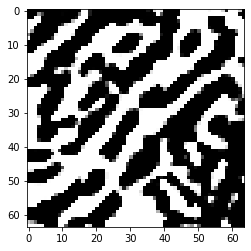

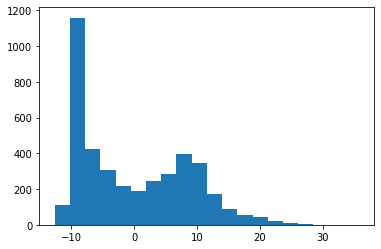

Iter:  8200
Energy Loss: 	0.00329
Sum Loss: 	0.04688
Norm Loss: 	0.01753


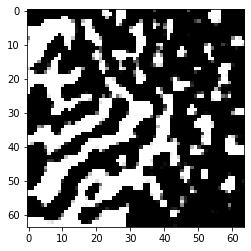

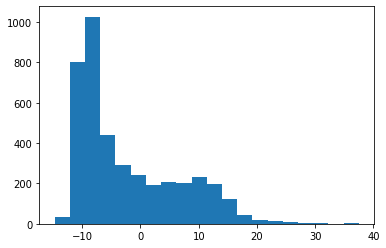

Iter:  8300
Energy Loss: 	0.00315
Sum Loss: 	0.05010
Norm Loss: 	0.01646


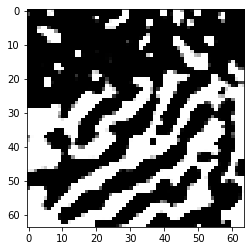

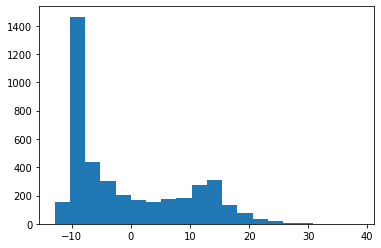

Iter:  8400
Energy Loss: 	0.00733
Sum Loss: 	0.03987
Norm Loss: 	0.01761


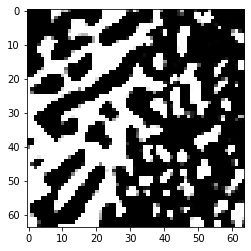

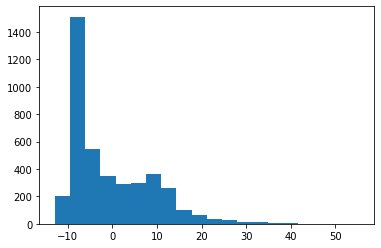

Iter:  8500
Energy Loss: 	0.00308
Sum Loss: 	0.04595
Norm Loss: 	0.01752


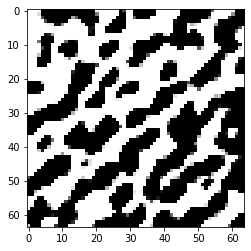

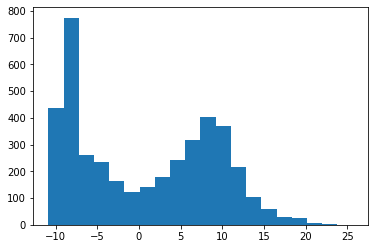

Iter:  8600
Energy Loss: 	0.00753
Sum Loss: 	0.03921
Norm Loss: 	0.02116


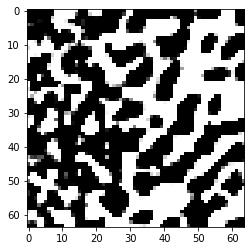

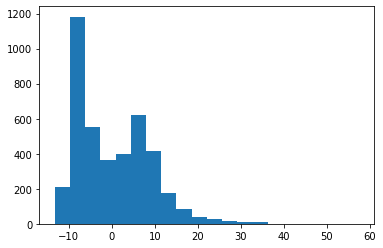

Iter:  8700
Energy Loss: 	0.00594
Sum Loss: 	0.03993
Norm Loss: 	0.01780


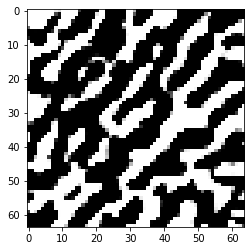

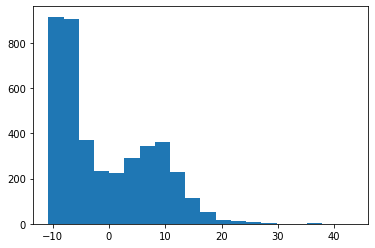

Iter:  8800
Energy Loss: 	0.00418
Sum Loss: 	0.04544
Norm Loss: 	0.01973


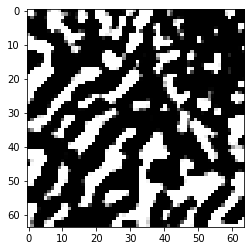

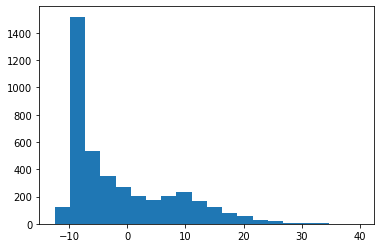

Iter:  8900
Energy Loss: 	0.00259
Sum Loss: 	0.04733
Norm Loss: 	0.01691


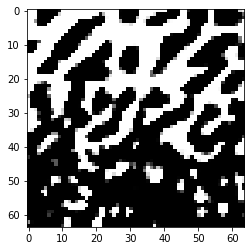

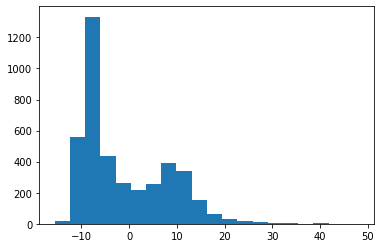

Iter:  9000
Energy Loss: 	0.00425
Sum Loss: 	0.04063
Norm Loss: 	0.01791


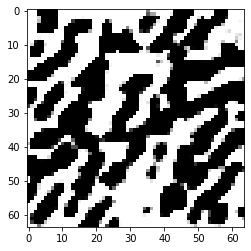

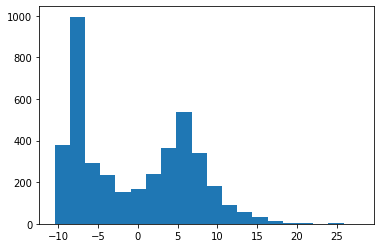

Iter:  9100
Energy Loss: 	0.00413
Sum Loss: 	0.04344
Norm Loss: 	0.01616


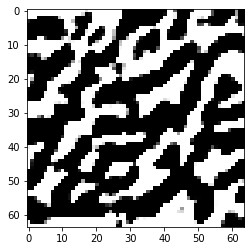

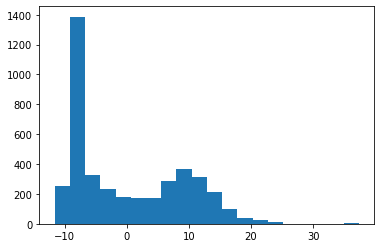

Iter:  9200
Energy Loss: 	0.00296
Sum Loss: 	0.04512
Norm Loss: 	0.01632


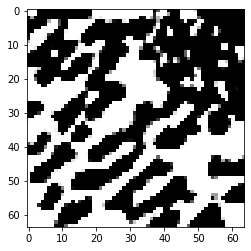

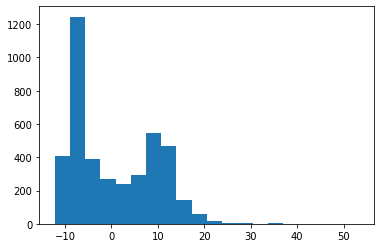

Iter:  9300
Energy Loss: 	0.00400
Sum Loss: 	0.04306
Norm Loss: 	0.01876


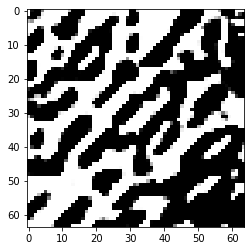

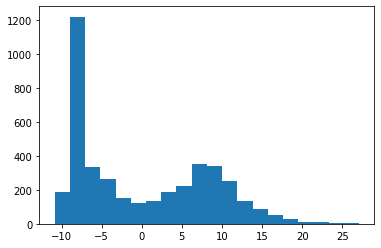

Iter:  9400
Energy Loss: 	0.01073
Sum Loss: 	0.03921
Norm Loss: 	0.02185


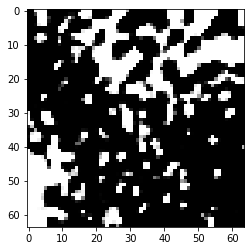

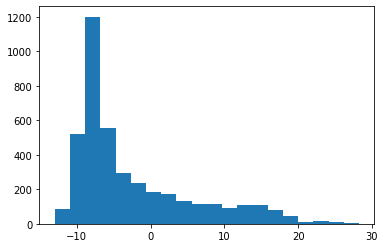

Iter:  9500
Energy Loss: 	0.00527
Sum Loss: 	0.03934
Norm Loss: 	0.01891


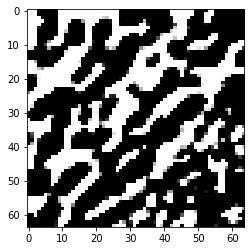

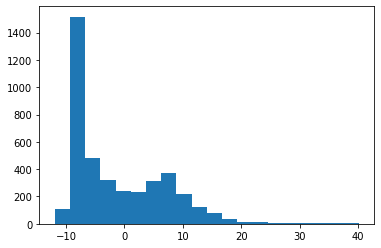

Iter:  9600
Energy Loss: 	0.00447
Sum Loss: 	0.03953
Norm Loss: 	0.01809


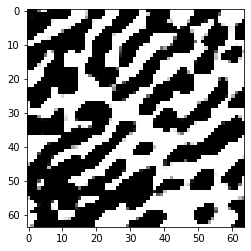

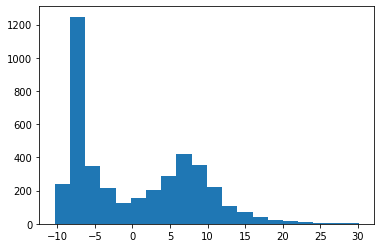

Iter:  9700
Energy Loss: 	0.00288
Sum Loss: 	0.04434
Norm Loss: 	0.01560


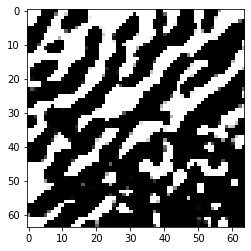

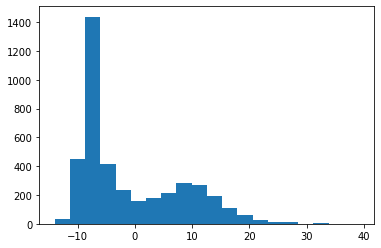

Iter:  9800
Energy Loss: 	0.00334
Sum Loss: 	0.04156
Norm Loss: 	0.01580


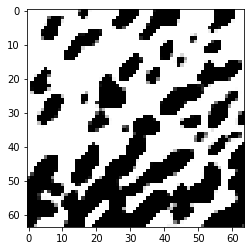

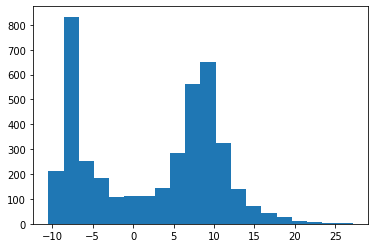

Iter:  9900
Energy Loss: 	0.00391
Sum Loss: 	0.04049
Norm Loss: 	0.01559


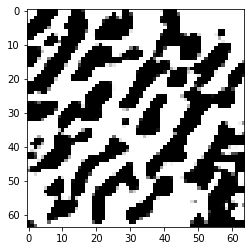

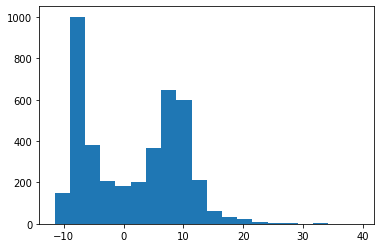

In [35]:
for i in range(10000):
#     norms = sample_norms(n).to(cuda)
#     x = torch.randn(n, d_model).to(cuda) / np.sqrt(d_model)
#     x = norms.unsqueeze(1) * x
#     energy_ratios = energy_beta_func(norms)
#     target_energy = energy_ratios * e_max
    x = torch.randn(n, d_model).to(cuda)
    lattice1, y = IsingModel(x)
    sum_loss = 1 - torch.mean(torch.square(lattice1))
    norm_loss = torch.mean(torch.pow(torch.linalg.norm(y, dim=(2,3))/(64*64), 2))
    energy_loss = torch.square(torch_lattice_energy(lattice1)/e_max + beta)
    energy_loss = energy_loss.mean()
    loss = sum_loss + 2*energy_loss + norm_loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0:
        lattice1, y = IsingModel(x)
        print("Iter: ", i)
        print("Energy Loss: \t{:.5f}".format(energy_loss.item()))
        print("Sum Loss: \t{:.5f}".format(sum_loss.item()))
        print("Norm Loss: \t{:.5f}".format(norm_loss.item()))
        plt.imshow(lattice1[0].detach().cpu(), cmap='gray')
        plt.show()
        plt.hist(y[0].flatten().detach().cpu(), bins=20)
        plt.show()

In [ ]:
torch_lattice_energy(image)

In [ ]:
for i in range(10):
    print(lattice_energy(image[i].detach().numpy()))

In [ ]:
for i in range(10):
    print(image[i].sum().item()**2)

In [137]:
torch.sum(image, (1, 2))

tensor([-1448.,  1058.,  1144.,  2448.,   278.,  3132.,  1234.,  2482.,  6082.,
         3536.], grad_fn=<SumBackward1>)